In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Imports
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision

from IPython.display import display
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from numpy.random import choice

import random
import time
from collections import deque

import sys
import os

from collections import defaultdict, namedtuple
from sklearn.cluster import DBSCAN

import cv2

import pickle
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import time
import json
import argparse

from path import Path
from typing import Type, Any, Callable, Union, List, Optional

print(sys.version)



print('python: ' + str(sys.version))
print('torch: ' + str(torch.__version__))
print('torchvision: ' + str(torchvision.__version__))

3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
python: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
torch: 1.12.1
torchvision: 0.13.1


In [52]:
#Training Paramaters
iterations = 30000
batch_size = 90 #90
learning_rate = 0.0001 #0.00006
way = 25
caching = False
modelPath = './wordsiamese/model/'

data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])
net_input_size = (448, 448)
net_output_size = (224, 224)
data_dir = Path('./wordsiamese/data/')
minimum_data_samples = 3 #minimum number of samples of a word for that word to be used 2 maybe 2

In [4]:
#Datasets and Loading
class WordSet(Dataset):
    def __init__(self, path, testing=False, transform = None, way=None, num_tests=None):
        super(WordSet, self).__init__()
        self.transform = transform
        self.images, self.class_count = self.loadTTImages('./wordsiamese/data/croppedImages')
        self.testing=testing
        self.num_tests = num_tests
        self.way = way
        self.classA, self.imgA = None, None #allows for n-way learning
        
    def loadTTImages(self, path):
        images = {} #stores all images loaded with identical character under one key
        idCount = 0 #number of different character types
        for word in os.listdir(path): #language character comes from
            word = str(word)
            images[word] = []
            idCount += 1
            for individualTest in os.listdir(os.path.join(path, word)): #each character image
                f_path = os.path.join(path, word, individualTest)
                #images[idCount].append(Image.open(f_path))
                images[word].append(f_path)
                
        print(f'idCount: {idCount}')
        return images, idCount
    
    def loadData(self, path):
        images = {} #stores all images loaded with identical character under one key
        idCount = 0 #number of different character types
        
        gt_dir = path / 'gt'
        img_dir = path / 'img'
        
        for gt in sorted(gt_dir.files('*.xml')):
            img = img_dir / gt.stem + '.png'
            if not img.exists():
                continue
            
            tree = ET.parse(gt)
            root = tree.getroot()
            
            # go over all lines
            for line in root.findall("./handwritten-part/line"):

                # go over all words
                for word in line.findall('./word'):
                    xmin, xmax, ymin, ymax = float('inf'), 0, float('inf'), 0
                    success = False
                    
                    id_word = word.attrib['text'].lower()
                    if id_word == '\"':
                        id_word = 'double_quote_mark'
                    elif id_word == '#':
                        id_word = 'pound_mark'
                    elif id_word == '&':
                        id_word = 'ampersand'
                    elif id_word == '{':
                        id_word = 'left_curly_mark'
                    elif id_word == '}':
                        id_word = 'right_curly_mark'
                    elif id_word == '*':
                        id_word = 'asterisk_mark'
                    elif id_word == '$':
                        id_word = 'dollar_mark'
                    elif id_word == '\'':
                        id_word = 'single_quote_mark'
                    elif id_word == ':':
                        id_word = 'colon_mark'
                    elif id_word == '!':
                        id_word = 'exclamation_mark'
                    elif id_word == '?':
                        id_word = 'question_mark'
                    elif id_word == '.':
                        id_word = 'period_mark'
                    elif '.' in id_word or '\"' in id_word:
                        continue
                        
                    # go over all characters
                    for cmp in word.findall('./cmp'):
                        success = True
                        x = float(cmp.attrib['x'])
                        y = float(cmp.attrib['y'])
                        w = float(cmp.attrib['width'])
                        h = float(cmp.attrib['height'])

                        # aabb around all characters is aabb around word
                        xmin = min(xmin, x)
                        xmax = max(xmax, x + w)
                        ymin = min(ymin, y)
                        ymax = max(ymax, y + h)

                    if success:
                        if not id_word in images.keys():
                            idCount += 1
                            images[id_word] = []
                        images[id_word].append(((xmin, ymin, xmax, ymax), img))
        
        remove = []
        for key in images.keys():
                if len(images[key]) < minimum_data_samples:
                    remove.append(key)
        
        print(len(images.keys())-len(remove))
        
        for r in remove:
            images.pop(r)
            
        self.images = images
        return images, idCount
    
    def saveImages(self):
        count = 0
        print(len(self.images.keys()))
        for key in self.images.keys():
            count += 1
            os.mkdir(f'./wordsiamese/data/croppedImages/{key}/')
            i = 0
            shuffled_key = random.sample(self.images[key], len(self.images[key]))
            for img in shuffled_key:
                
                img_box = img[0]
                img_img = img[1]

                # Opens a image in RGB mode
                img_img = Image.open(img_img)
                img_crop = img_img.crop(img_box).convert('L').resize((105, 105))                
                
                
                try:
                    img_crop.save(f"./wordsiamese/data/croppedImages/{key}/{i:04d}.jpg")
                except:
                    print(count, key)
                    print('saving exception failed due to complicated keys')
                i += 1
                if i > 20:
                    break
    
    def __getitem__(self, i):
        label, imgA, imgB, idClassA, idClassB = None, None, None, None, None
        
        # i ensures that theres a mix of same and different sets
        if self.testing:
            if i % self.way == 0:
                self.classA = random.choice(list(self.images.keys()))
                self.imgA = random.choice(self.images[self.classA])
                imgB = random.choice(self.images[self.classA])
                while imgB == self.imgA:
                    imgB = random.choice(self.images[self.classA])

                
                idClassA = self.classA
                
                #print(f'Word: {idClassA}')
                

            #different class
            else:
                idClassB = random.choice(list(self.images.keys()))#set B every time but A only n-way times
                while self.classA == idClassB: #prevents same class
                    idClassB = random.choice(list(self.images.keys()))
                imgB = random.choice(self.images[idClassB])
                
                idClassA = self.classA
                
            imgA = self.imgA
            
            label = label = torch.from_numpy(np.array([-1.00], dtype=np.float32))
            
        else:
            #same class
            if i % 2 == 1:
                label = torch.from_numpy(np.array([1.00], dtype=np.float32))
                idClass = random.choice(list(self.images.keys()))
                imgA, imgB = random.choice(self.images[idClass]), random.choice(self.images[idClass])
                while imgB == imgA:
                    imgB = random.choice(self.images[idClass])

            #different class
            else:
                label = torch.from_numpy(np.array([0.00], dtype=np.float32))
                idClassA, idClassB = random.choice(list(self.images.keys())), random.choice(list(self.images.keys()))
                while idClassA == idClassB: #prevents same class
                    idClassB = random.choice(list(self.images.keys()))
                imgA = random.choice(self.images[idClassA])
                imgB = random.choice(self.images[idClassB])
    
        
        #print('a', imgA)
        #print('b', imgB)
        
        # Opens a image in black and white mode
        imgA = Image.open(imgA).convert('L')
        imgB = Image.open(imgB).convert('L')
        
        #if i % self.way == 0:
        #    print(f'Img A: {idClassA}')
        #    plt.imshow(imgA)
        #    plt.show()

        #print(f'Img B: {idClassB}')
        #plt.imshow(imgB)
        #plt.show()
        
        imgA = self.transform(imgA)
        imgB = self.transform(imgB)

        
        return imgA, imgB, label
    
    def __len__(self):
        if self.testing:
            return self.num_tests * self.way
        else:
            return  21000000 #5250000

    
    

In [34]:
class DeterminationSet(Dataset):
    def __init__(self, path, transform = None, uk=None):
        super(DeterminationSet, self).__init__()
        self.transform = transform
        self.images, self.class_count, self.keys = self.loadTTImages('./wordsiamese/data/croppedImages')
        self.count_i = 0
        self.uk = uk
        
    def loadTTImages(self, path):
        images = {} #stores all images loaded with identical character under one key
        idCount = 0 #number of different character types
        keys = []
        for word in os.listdir(path): #language character comes from
            word = str(word)
            images[word] = []
            keys.append(word)
            idCount += 1
            for individualTest in os.listdir(os.path.join(path, word)): #each character image
                f_path = os.path.join(path, word, individualTest)
                images[word].append(f_path)           
        return images, idCount, keys
    
    def __getitem__(self, i):
        idClass = self.keys[self.count_i]
        img = random.choice(self.images[idClass])
        img = Image.open(img).convert('L')
        img = self.transform(img)
        
        self.count_i += 1
        return self.uk, img
    
    def __len__(self):
        return self.class_count

In [37]:
#Data preperations

def DataPrep():
    trainSet = WordSet(data_dir, transform=data_transforms)
    #trainSet.loadData(data_dir)
    #trainSet.saveImages()
    testSet = WordSet(data_dir, transform=transforms.ToTensor(), testing=True, num_tests = 400, way = way)

    trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=False, num_workers=0)
    testLoader = DataLoader(testSet, batch_size=way, shuffle=False, num_workers=0)
    
    return trainLoader, testLoader

def DeterminationPrep(unknown):
    data_set = DeterminationSet(data_dir, transform=transforms.ToTensor(), uk=unknown)
    data_loader = DataLoader(data_set, batch_size=way, shuffle=False, num_workers=0)
    return data_loader

if __name__ == '__main__':
    #DataPrep()
    #DeterminationPrep()
    print(True)

True


In [7]:
#Check GPU
device = torch.device("cuda:" + str(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu")
print((str(device) + " - " + str(torch.cuda.get_device_name(torch.cuda.current_device()))))

cuda:0 - NVIDIA GeForce GTX 1650 SUPER


In [8]:
#Siamese Model
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #return self.sigmoid(out)
        return out
    
if __name__ == '__main__':
    net = Siamese()
    print(net)
    

Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)


In [ ]:
#Train

print('initializing training')

loss_function = torch.nn.BCEWithLogitsLoss()#default for size average is true
loss_value = 0
loss_values = []







accuracies = []
a_assist = []

checkpoint = torch.load('./wordsiamese/model/training-model-26400.pt')

network = Siamese() #creates a new network
network.load_state_dict(checkpoint['model_state_dict'])
network.to(device)
network.train() #sets the mode of the network to training

optimizer = torch.optim.Adam(network.parameters(), lr = learning_rate)
optimizer.zero_grad() #zeros out the gradients
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


cepoch = int(checkpoint['epoch'])

checkpoint = None



start_time = time.time()
initial_start_time = start_time
print('starting training loop')
for i, (imgA, imgB, label) in enumerate(trainLoader, start=1):
    if i + cepoch > iterations:
        break
    
    imgA = Variable(imgA.to(device))#.cuda
    imgB = Variable(imgB.to(device))#.cuda
    label = Variable(label.to(device))
    
    optimizer.zero_grad() #zeros out the gradients since paramaters already updated with old gradient
    
    output = network.forward(imgA, imgB) #gets similarity probability
    
    loss = loss_function(output, label)
    
    li = loss.item()
    
    loss_value += li
    loss_values.append(li)
    loss.backward() #computes the gradient of loss for all parameters
    
    optimizer.step() #updates parameters
    
    #print updates for the user
    if i % 10 == 0:
        print(f'{i + cepoch} loss: {loss_value/10} time elapsed: {time.time()-start_time}')
        loss_value = 0
        start_time = time.time()
        if i % 100 == 0:
            correct, wrong = 0, 0
            for _, (testA, testB, _) in enumerate(testLoader, 1):
                testA, testB = Variable(testA.to(device)), Variable(testB.to(device))
                output = network.forward(testA, testB).data.cpu().numpy() #computes the probability
                prediction = np.argmax(output) #gets the index of highest value in output
                if prediction == 0:
                    correct += 1
                else:
                    wrong += 1

            print('-'*100)
            print(f'{i + cepoch} Testing Set Correct: {correct} Wrong: {wrong} Precision: {correct*1.0/(correct + wrong)}')
            print('-'*100)
            accuracies.append(correct*1.0/(correct+wrong))
            a_assist.append(i)
            if i % 300 == 0:
                print('saving...')
                torch.save({
                    'epoch': i + cepoch,
                    'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_value,
                    }, f'{modelPath}training-model-{i + cepoch}.pt')


print('finish training loop, time elapsed: ', str(time.time()-initial_start_time))
    
#add final accuracies
accuracy = 0.0
counter = 0
for d in accuracies:
    print(d)
    accuracy += d
    counter += 1
print("#"*100)
print("final accuracy: ", accuracy/counter)
    

In [ ]:
#define subplots
fig, ax = plt.subplots(2, 1, figsize=(15,20))
#fig.tight_layout()

#create subplots
ax[0].plot(range(1, iterations + 1), loss_values, color='red')
ax[0].set_title('Loss Values During Training')
ax[0].set_ylabel('Loss Value')
ax[0].set_xlabel('Epoch')
ax[1].plot(a_assist, accuracies, color='blue')
ax[1].set_title('Accuracies During Training')
ax[1].set_ylabel('Accuracies')
ax[1].set_xlabel('Epoch')

AttributeError: 'function' object has no attribute 'show'

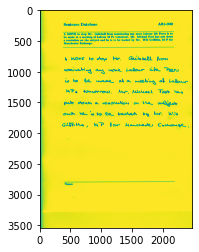

In [9]:
#Test Image Loading
imgT=mpimg.imread('./wordsiamese/data/img/a01-000u.png')
plt.imshow(imgT)

im = Image.open('./wordsiamese/data/img/a01-000u.png')
 
newsize = (800, 300)
im1 = im.resize
# Shows the image in image viewer
im.show()
im1.show()

In [ ]:
accuracies = {}

In [ ]:
checkpoint = torch.load('./wordsiamese/model/training-model-26100.pt')

network = Siamese() #creates a new network
network.load_state_dict(checkpoint['model_state_dict'])
network.to(device)
network.eval() #sets the mode of the network to training

print('begin testing')
for w in range(25, 500, 25):
    counter = 0
    way = w
    trainLoader, testLoader = DataPrep()
    print(f'Way: {way}')
    rw_ratio = [0, 0]
    for _, (testA, testB, _) in enumerate(testLoader, 1):
            counter += 1
            testA, testB = Variable(testA.to(device)), Variable(testB.to(device))
            output = network.forward(testA, testB).data.cpu().numpy() #computes the probability
            print(np.append(output, output))
            #print(output)
            prediction = np.argmax(output) #gets the index of highest value in output
            #print(f'Prediction: {prediction}')
            if prediction == 0:
                #print('correct')
                rw_ratio[0] += 1
            else:
                #print('wrong')
                rw_ratio[1] += 1
            if counter > 999:
                break
            break
            #print(f'Test: {counter}')
    accuracies[way] = rw_ratio

In [ ]:
print(accuracies)

In [ ]:
#define subplots
fig, ax = plt.subplots(1, 1, figsize=(15,20))
#fig.tight_layout()

a = []
for i in list(accuracies.keys()):
    a.append(accuracies[i][0]/400)

print(a)

k = list(accuracies.keys())
print(k, type(k[0]))

#create subplots
ax.plot(k, a, color='red')
ax.set_title('Accuracies n-way')
ax.set_ylabel('Accuracy')
ax.set_xlabel('n-way')

In [53]:
checkpoint = torch.load('./wordsiamese/model/training-model-26100.pt')

network = Siamese() #creates a new network
network.load_state_dict(checkpoint['model_state_dict'])
network.to(device)
network.eval() #sets the mode of the network to training

print('begin image testing')

output = np.array([])

#INSERT UNKNOWN IMAGE HERE

unknown = './wordsiamese/data/testingData/0020.jpg'

##########################

utrans = transforms.ToTensor()

unknown = Image.open(unknown).convert('L')
unknown = utrans(unknown)


IMGLoader = DeterminationPrep(unknown)

keyList = []
for word in os.listdir('./wordsiamese/data/croppedImages'): #language character comes from
    keyList.append(word)

for _, (uk, testIMG) in enumerate(IMGLoader, 1):
    testIMG = Variable(testIMG.to(device))
    uk = Variable(uk.to(device))
    result = network.forward(uk, testIMG).data.cpu().numpy()
    output = np.append(output, result) #computes the probability

failiures = 1
prediction = np.argmax(output)
while not keyList[prediction] == 'a':
    prediction = np.argmax(output) #gets the index of highest value in output
    #Prints the key for the word based on the index of the highest value
    print(f'Prediction: {keyList[prediction]}, {output[prediction]}')
    output[prediction] *= -1
    failiures += 1
print(failiures)

begin image testing
Prediction: let, 6.007425785064697
Prediction: so, 5.777673244476318
Prediction: set, 5.452515125274658
Prediction: du, 5.18389892578125
Prediction: or, 4.921357154846191
Prediction: mr, 4.893509387969971
Prediction: st, 4.843031406402588
Prediction: for, 4.787543296813965
Prediction: eat, 4.443705081939697
Prediction: who, 4.4025492668151855
Prediction: us, 4.261566162109375
Prediction: do, 4.223324298858643
Prediction: tv, 4.170348167419434
Prediction: 've, 4.15179967880249
Prediction: lit, 4.104058265686035
Prediction: act, 4.068676471710205
Prediction: etc, 4.00346040725708
Prediction: says, 3.9784774780273438
Prediction: ampersand, 3.9755473136901855
Prediction: all, 3.821568489074707
Prediction: sea, 3.719973087310791
Prediction: 'll, 3.6847476959228516
Prediction: pin, 3.6840810775756836
Prediction: also, 3.6751980781555176
Prediction: as, 3.5990800857543945
Prediction: est, 3.5825653076171875
Prediction: can, 3.567607879638672
Prediction: sole, 3.49899148941